# Data augmentation

Based on https://arxiv.org/pdf/1710.01927.pdf

In [49]:
from data_loader import load_data
import numpy as np
import matplotlib.pyplot as plt
import random
from statistics import mean

In [50]:
X, Y, groups, coord = load_data()

## CTRL augmentation

In [51]:
spectrumID = 531
spectrum = X[spectrumID]
x_axis = coord[spectrumID]

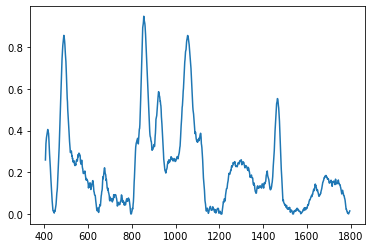

In [52]:
plt.plot(x_axis, spectrum)

In [53]:
def standard_deviation_mean(X):
    full=[]
    for i in X:
        for j in i:
            full.append(j)
    return np.std(full), mean(full)

In [54]:
stdf, meanf = standard_deviation_mean(X)

## Offset : 0,1 x Standard deviation of dataset

In [68]:
def offset(spectrum):
    X_offset=[]
    r=random.sample([-0.1,0.1], 1)[0]
    for i in spectrum:
        res = i+(r*stdf)
        if res > 0:
            X_offset.append(res)
        else:
            X_offset.append(0)
    return X_offset

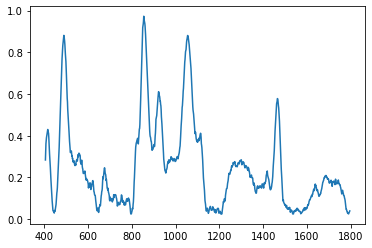

In [69]:
plt.plot(x_axis, offset(spectrum))

## Multiplication : 1+- 0,1 x std

In [70]:
def multiplication(spectrum):
    X_multiplication=[]
    r=random.uniform(0.9, 1.1)
    for i in X[531]:
        X_multiplication.append(i*r*stdf)
    return X_multiplication

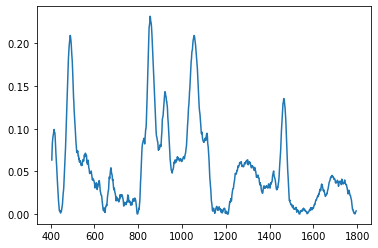

In [71]:
plt.plot(x_axis, multiplication(spectrum))

## Gaussian noise

In [72]:
def gaussian_noise(spectrum):
    noise = np.random.normal(meanf,stdf,len(spectrum))
    X_gaussian = []
    for i in range(len(spectrum)):
        res = spectrum[i]+noise[i]
        if res > 0:
            X_gaussian.append(res)
        else:
            X_gaussian.append(0)
    return X_gaussian

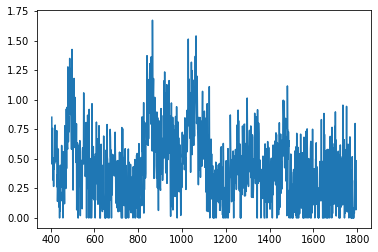

In [73]:
plt.plot(x_axis, gaussian_noise(spectrum))

### Sum up of all the methods visually

In [79]:
def data_augmentation(spectrum):
    return offset(spectrum), multiplication(spectrum), gaussian_noise(spectrum)

In [80]:
offset, multiplication, gaussian_noise = data_augmentation(spectrum)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Some spectra')
ax1.plot(x_axis, spectrum)
ax2.plot(x_axis, offset, 'tab:orange')
ax3.plot(x_axis, multiplication, 'tab:green')
ax4.plot(x_axis, gaussian_noise, 'tab:red')

for ax in fig.get_axes():
    ax.label_outer()

TypeError: 'list' object is not callable

## Transfer learning with data augmentation 